In [86]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats

In [87]:
import torchvision
import torchvision.transforms as T
mnist_train = torchvision.datasets.MNIST('../data', train=True, download=True)
mnist_test = torchvision.datasets.MNIST('../data', train=False, download=True)

In [88]:
print(mnist_train.data.size(), mnist_train.targets.size())
mnist_test.data.size(), mnist_test.targets.size()

torch.Size([60000, 28, 28]) torch.Size([60000])


(torch.Size([10000, 28, 28]), torch.Size([10000]))

In [89]:
mnist_train_flat = torchvision.datasets.MNIST(root='../data', download=True, transform=T.ToTensor())

In [90]:
len(mnist_train_flat)

60000

In [116]:
data_t = [img.reshape([-1]) for img, target in mnist_train_flat]

In [117]:
data_t[0]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [121]:
data = torch.tensor(np.array(data_t)).float()

In [122]:
data.shape

torch.Size([60000, 784])

In [123]:
def create_mnist_ae():
    class MNISTAE(nn.Module):
        def __init__(self, *args, **kwargs) -> None:
            super().__init__(*args, **kwargs)
            # input
            self.input = nn.Linear(784, 250)
            # encoding
            self.enc = nn.Linear(250, 50)
            # latent/bottleneck
            self.lat = nn.Linear(50, 250)
            # decoding
            self.dec = nn.Linear(250, 784)

        def forward(self, x):
            x = torch.relu(self.input(x))
            x = torch.relu(self.enc(x))
            x = torch.relu(self.lat(x))
            y = torch.sigmoid(self.dec(x)) # as data is 0-1, output is also 0-1
            return y
        
    net = MNISTAE()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    lossfunc = nn.MSELoss()

    return net, lossfunc, optimizer

In [124]:
net, lossfunc, optimizer = create_mnist_ae()

In [131]:
X = data[:5,:]
y_pred = net(X)
print(X.shape, y_pred.shape)

torch.Size([5, 784]) torch.Size([5, 784])


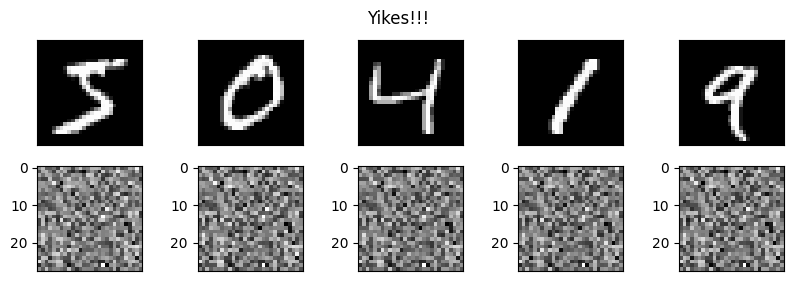

In [132]:
fig, ax = plt.subplots(2, 5, figsize=(10, 3))

for i in range(5):
    ax[0, i].imshow(X[i].view(28, 28).detach(), cmap='gray')
    ax[1, i].imshow(y_pred[i].view(28, 28).detach(), cmap='gray')
    ax[0, i].set_xticks([]), ax[0, i].set_yticks([])
    ax[1, i].set_xticks([]), ax[0, i].set_yticks([])

plt.suptitle("Yikes!!!")
plt.show()

In [142]:
def train_model():
    epochs = 10_000
    net, lossfunc, optimizer = create_mnist_ae()
    losses = torch.zeros(epochs)

    for e in range(epochs):
        # random images from data
        random_idxs = np.random.choice(data.shape[0], size=32)
        x = data[random_idxs,:]
        y_pred = net(x)
        loss = lossfunc(y_pred, x)
        losses[e] = loss.detach().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return losses, net

In [143]:
losses, net = train_model()

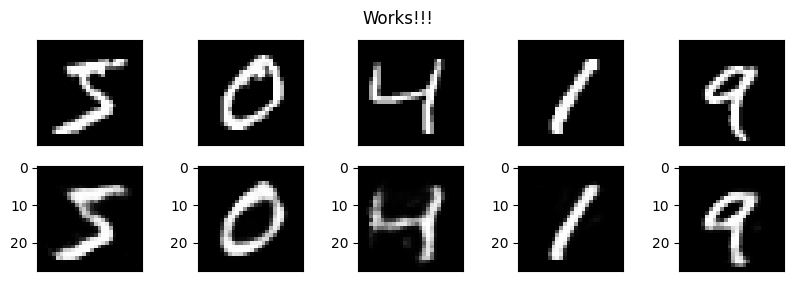

In [144]:
y_pred = net(X)
fig, ax = plt.subplots(2, 5, figsize=(10, 3))

for i in range(5):
    ax[0, i].imshow(X[i].view(28, 28).detach(), cmap='gray')
    ax[1, i].imshow(y_pred[i].view(28, 28).detach(), cmap='gray')
    ax[0, i].set_xticks([]), ax[0, i].set_yticks([])
    ax[1, i].set_xticks([]), ax[0, i].set_yticks([])

plt.suptitle("Works!!!")
plt.show()

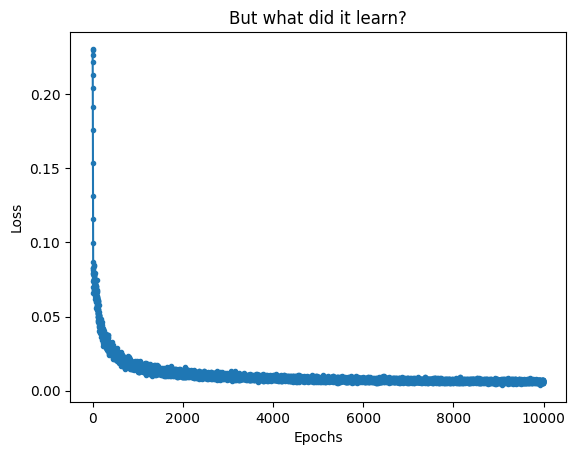

In [145]:
plt.plot(losses, '.-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("But what did it learn?")
plt.show()

In [146]:
# Noise demo

In [147]:
x = data[:10,:]
x_noise = x + torch.rand_like(x)/4
x_noise[x_noise>1] = 1 # clip at 1

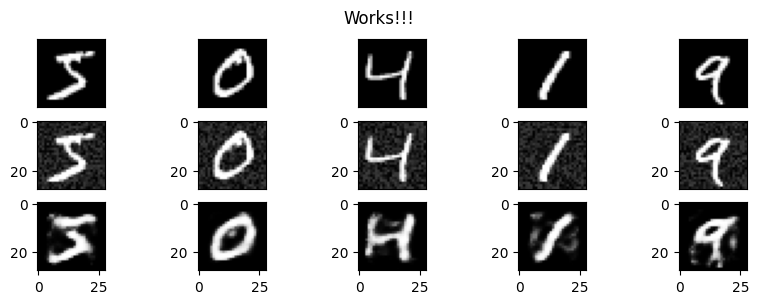

In [154]:
y_pred = net(x_noise)
fig, ax = plt.subplots(3, 5, figsize=(10, 3))

for i in range(5):
    ax[0, i].imshow(x[i].view(28, 28).detach(), cmap='gray')
    ax[1, i].imshow(x_noise[i].view(28, 28).detach(), cmap='gray')
    ax[2, i].imshow(y_pred[i].view(28, 28).detach(), cmap='gray')
    ax[0, i].set_xticks([]), ax[0, i].set_yticks([])
    ax[1, i].set_xticks([]), ax[0, i].set_yticks([])

plt.suptitle("Works!!!")
plt.show()